In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(50,40), dpi=300)
plt.rcParams["figure.figsize"] = (50,40)


from lifelines import KaplanMeierFitter, NelsonAalenFitter
from sklearn.cluster import KMeans
import datetime as dt
import re, os, random
import joblib

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import graphviz 
from sklearn.tree import export_graphviz


from sksurv.tree import SurvivalTree
from sksurv.util import Surv
from tree_exporter import plot_tree
from sklearn import tree


from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.stats import skew, kurtosis, entropy


np.random.seed(122)
random.seed(122)

import warnings
warnings.filterwarnings("ignore")

<Figure size 15000x12000 with 0 Axes>

In [2]:
def survive(data, duration, event, fitter='kaplan'):
    kmf = KaplanMeierFitter() if fitter == 'kaplan' else NelsonAalenFitter()
    kmf.fit(durations=data[duration], event_observed=data[event])
    print(kmf.event_table)
    return kmf, kmf.durations

In [3]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    shc.dendrogram(linkage_matrix, **kwargs)

In [4]:
def predect_node_for_missing_value(model, data): # this is a brute force solution. I beleive there is a better one can be found
    """This function build the tree structure then select a node for it iff it has missing values """
    if any(elem is None for elem in data) or any(elem is np.nan for elem in data):
        pass
    else: 
        return 0, "This person doesn't have any missing values"
    
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    name = model.feature_names_in_
    threshold = model.tree_.threshold
    samples = model.tree_.n_node_samples

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print( "The binary tree structure has {n} nodes, {l} leaves and has the following tree structure:\n".format(n=n_nodes, l=np.sum(is_leaves)))
    
    current_node = 0
    for i in range(n_nodes):
        print('current_node is', current_node, end=' ::: ')
        if is_leaves[i]:
            print("{space}node={node} is a leaf node.".format(space=node_depth[i] * "\t", node=i))
        else:
            if data[feature[i]] is np.nan or data[feature[i]] is None:
                if current_node == i:
                    print(f"{node_depth[i] * '    '}node={i} is a split node: go to node {children_left[i]} if node {children_left[i]} counts {samples[children_left[i]]} >= node{children_right[i]} counts{samples[children_right[i]]} else to node {children_right[i]}.")
                    if samples[children_left[i]] >= samples[children_right[i]]:
                        current_node = children_left[i]
                    elif samples[children_right[i]] > samples[children_left[i]]:
                        current_node = children_right[i]
            else:
                if current_node == i:
                    print(f"{node_depth[i] * '    '}node={i} is a split node: go to node {children_left[i]} if X[:, {feature[i]} {name[feature[i]]}] <= {threshold[i]} else to node {children_right[i]}.")
                    if data[feature[i]] <= threshold[i]:
                        current_node = children_left[i]
                        
                    elif data[feature[i]] > threshold[i]:
                        current_node = children_right[i]
        
        if is_leaves[current_node]:
            print(f'Node {current_node} is a leaf node. Its the node where this person will land')
            return current_node, np.argmax(model.tree_.value[current_node])
        
    return current_node, np.argmax(model.tree_.value[current_node])

In [8]:
METHOD1 = 'METHOD1'
METHOD2 = 'METHOD2'
METHOD3 = 'METHOD3'
MALE = 'male'
FEMALE = 'female'
CONTRIBUTORS = 'CONTRIBUTORS'
TARGET = 'TARGET'
MODEL = 'model'

In [9]:
ID = 'national_id_number'
LAST_JOB = 'last_job_c'
FIRST_JOB = 'first_job'
EXPERIENCE = 'experience'
AGE = 'age'
GOVERNORATE = 'governorate'
DISABILITY = 'disability'
GENDER = 'gender'
EDUCATION = 'education'
UNEMPLOYMENT_YAER = 'unemployment_year'
SAME_JOB = 'same_job'
WAGE = 'wage_adj_c'
POVERTY = 'poverty'
INDUSTRY = 'industry'
SPELL = 'unemployment_spell'
# EMPLOYMENT = 'employment'


NODES = 'nodes'
CLUSTER = 'clusters'
DURATIONS = 'durations'
NODES_DESTRO = 'nodes_destros'

In [10]:
ORIGINAL_COLUMNS = ['NationalID_Number', 'LastJobC' ,'FirstJob', 'experience', 'age', 'Governorate','Disability', 'Gender', 'education','UnemploymentYear','SameJob', 'wage_adj_c','Poverty', 'Industry','UnemploymentSpell']
PROCESSED_COLUMNS = [ID, LAST_JOB, FIRST_JOB, EXPERIENCE, AGE, GOVERNORATE, DISABILITY, GENDER, EDUCATION, UNEMPLOYMENT_YAER, SAME_JOB, WAGE, POVERTY, INDUSTRY, SPELL]

ONE_HOT_ENCODED_FEATURES = [GOVERNORATE, EDUCATION,]
LABEL_ENCODED_FEATURES = [GENDER, DISABILITY]

ENCODERS = {}
API_ENCODERS = {}


MINIMUM_LEAF_COUNT = 600
MINIMUM_DURATION_CUT = 60
MAXIMUM_DURATION_CUT = 1800

In [11]:
API_ATTRIBUTES = [EXPERIENCE, AGE, GOVERNORATE, DISABILITY, EDUCATION, GENDER]
API_CONTRIBUTORS = [EXPERIENCE, AGE, DISABILITY, GENDER, ] # nodes are to drop, clusters are the target
API_CONTRIBUTORS += [f'{GOVERNORATE}_{item}' for item in ['al_kirk', 'zarqa', 'amman', 'irbid', 'al_aqaba', 'jarash', 'balqa', 'maadaba', 'tafileh', 'ajloun', 'maan', 'al_mafraq', 'outside_jordan', ]]
API_CONTRIBUTORS += [f'{EDUCATION}_{item}' for item in ['secondary_or_below', 'vocational_training', 'bachelor_or_above', 'middle_diploma', ]]
API_TARGET = [CLUSTER]

METHODS = {
    METHOD1:{
        CONTRIBUTORS: [EXPERIENCE, AGE, GOVERNORATE, DISABILITY, EDUCATION, INDUSTRY,],
        TARGET:f'{SPELL}',
        MODEL:'DecisionTreeRegressor()'
    },
    METHOD2:{
        CONTRIBUTORS: [EXPERIENCE, AGE, GOVERNORATE, DISABILITY, EDUCATION, INDUSTRY,],
        TARGET:f"Surv.from_dataframe({LAST_JOB}, {SPELL}," + " {0})",
        MODEL:f'SurvivalTree(min_samples_leaf={MINIMUM_LEAF_COUNT})' 
    },
    METHOD3:{
        CONTRIBUTORS: [EXPERIENCE, AGE, GOVERNORATE, DISABILITY, EDUCATION,],
        TARGET:f"Surv.from_dataframe('{LAST_JOB}', '{SPELL}'," + " {0})",
        MODEL:f'SurvivalTree(min_samples_leaf={MINIMUM_LEAF_COUNT})'
    },
}

In [12]:
DATA_INPUT_PATH = os.path.join('.','data','Unemployment Data.dta')
DATA_OUTPUT_PATH = os.path.join('.','data','final_outputs.csv')
MODELS_OUTPUT_PATH = os.path.join('.','runs')

In [13]:
df = pd.read_stata(DATA_INPUT_PATH) # [['experience', 'Governorate', 'Name_tr', 'Disabled_tr', 'EducationalAttainment', 'JobSeekers_DateOfBirth', 'job_search_start']]
df.head()

,NationalID_Number,first_ind,last_ind,poverty_score,start_date,end_date,job_search_start,unempl_spell,raw_exp,experience,...,matched_hiredMOL,hired_MOL_office,_merge_with_mol,PS2,_merge_with_poverty,year,date,inflationrate,merge_inflation,infl_calc
0,2.000000e+09,1.0,1.0,NaN,2018-03-01,2019-01-01,NaT,NaN,NaN,0.0,...,1.0,0.0,matched (3),NaN,matched (3),2018.0,12/31/2018,4.4623,matched (3),1.044623
1,2.000000e+09,1.0,1.0,NaN,2019-03-01,2019-04-01,2019-02-25,3.546875,NaN,0.0,...,0.0,0.0,matched (3),NaN,matched (3),2019.0,12/31/2019,0.7615,matched (3),1.007615
2,2.000000e+09,1.0,0.0,NaN,2019-05-01,2020-02-01,2019-03-17,44.638672,NaN,0.0,...,1.0,0.0,matched (3),NaN,matched (3),2019.0,12/31/2019,0.7615,matched (3),1.007615
3,2.000000e+09,0.0,0.0,NaN,2020-03-01,2020-04-01,2020-02-01,29.000000,276.0,276.0,...,1.0,0.0,matched (3),NaN,matched (3),2020.0,,NaN,master only (1),NaN
4,2.000000e+09,0.0,0.0,NaN,2020-06-01,2020-07-01,2020-04-01,61.000000,31.0,307.0,...,1.0,0.0,matched (3),NaN,matched (3),2020.0,,NaN,master only (1),NaN


In [14]:
df.NationalID_Number = df.NationalID_Number.astype(str)
max_date = df.end_date.max()
con = np.logical_and(
    df.NationalID_Number == df.groupby(['NationalID_Number'])['NationalID_Number'].shift(1),
    df.reason_suspension_tr.isin(['Resignation', 'Laid off'])
)
df['RegisterAfterFired'] = np.where(con, 1, 0)
# NEEDS MORE ATTINTION
if 'METHOD3' == METHOD3:
    con = np.logical_and(
        df.last_ind == 1,
        df.reason_suspension_tr.isin(['Resignation', 'Laid off'])
    )
    df['LastJobC'] = np.where(con, 0, 1)
    
    # data$LastJobC[data$`_merge_with_mol`==2]         = 0
    # data$experience[data$`_merge_with_mol`==2]       = 0
    # data$end_date[data$`_merge_with_mol`==2]         = data$RegistrationdateintoNEES[data$`_merge_with_mol`==2]
    # data$econ_activity_tr[data$`_merge_with_mol`==2] = ''
    
    df_temp = df[df.last_ind == 1]
    # data$LastJobC               = 1
    df_temp.unempl_spell = pd.to_datetime(max_date) - pd.to_datetime(df_temp.end_date)
    df_temp.RegisterAfterFired = 1
    
    # data= rbind(data,dataTemp)  # this will create duplicate
df['validCase'] = np.where(df.first_ind == 1, 1, df.RegisterAfterFired)
con = np.logical_and(
    df.validCase == 1,
    np.logical_not(df.econ_activity_tr.isin(['Public administration, defense, and social security']))
)
df1 = df[con]
df1 = df1.dropna(subset=['unempl_spell'])
con = np.logical_and(
    df1.unempl_spell > MINIMUM_DURATION_CUT,
    df1.unempl_spell < MAXIMUM_DURATION_CUT,
)
df1 = df1[con]
df1.info() # this only what left after filtaring

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50944 entries, 13 to 308516
Data columns (total 64 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   NationalID_Number              50944 non-null  object        
 1   first_ind                      50944 non-null  float32       
 2   last_ind                       50944 non-null  float32       
 3   poverty_score                  1308 non-null   float32       
 4   start_date                     50944 non-null  datetime64[ns]
 5   end_date                       50109 non-null  datetime64[ns]
 6   job_search_start               50944 non-null  datetime64[ns]
 7   unempl_spell                   50944 non-null  float32       
 8   raw_exp                        42015 non-null  float32       
 9   experience                     50944 non-null  float32       
 10  RegistrationdateintoNEES       50944 non-null  datetime64[ns]
 11  rep_job      

In [15]:
def experience_code(value):
    if value > 15:
        return 20
    elif value > 10:
        return 15
    elif value > 5:
        return 10
    elif value > 1:
        return 5
    elif value > 0:
        return 1
    else:
        return 0
    
# - Dummy for first job:
df1['FirstJob'] = np.where(df1.first_ind == 1, 1, 0)

#  - Experience:
df1.experience = np.round(df1.experience / 365)
df1.experience = df1.experience.apply(experience_code)

# - Age:
df1['age'] = (df1.job_search_start - dt.datetime(1970,1,1)).dt.total_seconds().astype(int) - (df1.JobSeekers_DateOfBirth - dt.datetime(1970,1,1)).dt.total_seconds().astype(int)
df1['age'] = (np.round((df1['age'] / (60 * 60 * 24 * 365)) / 10) * 10).astype(int)

# - Governorate:
df1.Governorate = df1.Governorate.str.lower()

# - Disability:
df1['Disability'] = df1.Disabled_tr.str.lower()

# - Gender:
df1['Gender'] = df1.Name_tr.str.lower()


# - Education Level:
df1.EducationalAttainment[df1.EducationalAttainment.isin(["High Diploma", "Bachelor", "Masters", "PhD"])] = 'bachelor_or_above'
df1.EducationalAttainment[df1.EducationalAttainment.isin(["Vocational Training"])] = "Vocational Training"
df1.EducationalAttainment[df1.EducationalAttainment.isin(["Middle Diploma"])] = "Middle Diploma"
df1.EducationalAttainment[df1.EducationalAttainment.isin(["Secondary or Below"])] = "Secondary or Below"
df1 = df1.rename(columns = {'EducationalAttainment':'education'})

# - Year of unemployment:
df1['UnemploymentYear'] = 0


# - Same Job:
df1['SameJob'] = np.where(df1.rep_job == 1, 'Yes', 'No')

# - Poverty:
df1['Poverty'] =  df1.poverty_score.fillna(0)

# - Industry:
df1['Industry'] = df1.econ_activity_tr.str.lower()
if('METHOD2' == METHOD2): 
    df1['Industry'] =  df1['Industry'].replace(r'^\s*$', np.nan, regex=True)

# - Unemployment Spell:
df1['UnemploymentSpell'] = df1.unempl_spell / 30 # Measured in months.


# - Wages:
df1['wage_adj_c'] = df1[['wage_adj']].fillna(-1000).astype(np.int)
t = KMeans(n_clusters=4, init='k-means++', n_init=10).fit(df1[['wage_adj_c']])
# clustered_data = t.fit_transform(df1[['wage_adj_c']])
df1['wage_adj_c'] = df1[['wage_adj_c']].groupby(t.labels_).transform('mean').sum(1).rank(method='dense').sub(1).astype(np.int64).to_frame()
# clusters_mean = []
# for i in range(t.n_clusters):
#     clusters_mean.append(clustered_data[:, i].mean())
#     print(clusters_mean)

print(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50944 entries, 13 to 308516
Data columns (total 73 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   NationalID_Number              50944 non-null  object        
 1   first_ind                      50944 non-null  float32       
 2   last_ind                       50944 non-null  float32       
 3   poverty_score                  1308 non-null   float32       
 4   start_date                     50944 non-null  datetime64[ns]
 5   end_date                       50109 non-null  datetime64[ns]
 6   job_search_start               50944 non-null  datetime64[ns]
 7   unempl_spell                   50944 non-null  float32       
 8   raw_exp                        42015 non-null  float32       
 9   experience                     50944 non-null  int64         
 10  RegistrationdateintoNEES       50944 non-null  datetime64[ns]
 11  rep_job      

,NationalID_Number,first_ind,last_ind,poverty_score,start_date,end_date,job_search_start,unempl_spell,raw_exp,experience,...,validCase,FirstJob,age,Disability,UnemploymentYear,SameJob,Poverty,Industry,UnemploymentSpell,wage_adj_c
13,2000000113.0,0.0,0.0,NaN,2019-03-01,2019-07-01,2018-10-01,151.000000,61.0,0,...,1,0,20,no disability,0,Yes,0.0,industry,5.033333,1
36,2000000282.0,0.0,0.0,NaN,2018-01-01,2018-07-01,2017-08-01,153.000000,365.0,1,...,1,0,20,no disability,0,Yes,0.0,industry,5.100000,1
44,2000000286.0,0.0,0.0,NaN,2019-05-01,2019-07-01,2017-09-01,607.000000,31.0,0,...,1,0,20,no disability,0,No,0.0,wholesale and retail trade,20.233334,1
63,2000000372.0,1.0,1.0,NaN,2019-06-01,2019-07-01,2018-12-06,176.453125,NaN,0,...,1,1,20,no disability,0,No,0.0,industry,5.881771,1
66,2000000385.0,0.0,1.0,NaN,2019-04-01,2019-11-01,2019-01-01,90.000000,275.0,1,...,1,0,20,no disability,0,No,0.0,real estate activities,3.000000,1


In [16]:
# for i in ORIGINAL_COLUMNS:
#     if i not in list(df1.columns):
#         print(i)
fdf = df1[ORIGINAL_COLUMNS].dropna()
print(fdf.info())
print('-' * 100)
for col in fdf.columns:
    print(col, '----------->', len(fdf[col].unique()))
    print(fdf[col].unique(), '\n\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50711 entries, 13 to 308516
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NationalID_Number  50711 non-null  object 
 1   LastJobC           50711 non-null  int32  
 2   FirstJob           50711 non-null  int32  
 3   experience         50711 non-null  int64  
 4   age                50711 non-null  int32  
 5   Governorate        50711 non-null  object 
 6   Disability         50711 non-null  object 
 7   Gender             50711 non-null  object 
 8   education          50711 non-null  object 
 9   UnemploymentYear   50711 non-null  int64  
 10  SameJob            50711 non-null  object 
 11  wage_adj_c         50711 non-null  int64  
 12  Poverty            50711 non-null  float32
 13  Industry           50711 non-null  object 
 14  UnemploymentSpell  50711 non-null  float32
dtypes: float32(2), int32(3), int64(3), object(7)
memory usage: 5.2+ MB
N

In [17]:
def unify_column_names(df):
    cols = []
    for col in df.columns:
        col = re.sub(r"(\w)([A-Z])", r"\1 \2", col)
        cols.append(col.strip(' .()[]{}/\#@*^!?').replace('_', ' ').replace(' ', '_').replace(',', '_').replace('__', '_').lower())
    df.columns = cols
    return df


def format_string_data(df):
    # unify dealing with strings data
    for col in df.select_dtypes(include=['object']):
        df[col] = df[col].str.replace(' ', '_')
        df[col] = df[col].str.replace('-', '_')
        df[col] = df[col].str.replace(',', '_')
        df[col] = df[col].str.replace('__', '_').str.lower()
    return df

def build_encoders(df, encoder_dict, save=False, label_encoded=LABEL_ENCODED_FEATURES, one_hot_encoded=ONE_HOT_ENCODED_FEATURES):
    for col in df.select_dtypes(include=['object']):
        
        if col in one_hot_encoded:
            
            encoder = OneHotEncoder()
            temp = pd.DataFrame(
                encoder.fit_transform(df[[col]]).toarray(),
                columns=list(encoder.get_feature_names_out())
            )
            df = pd.concat([df, temp], axis=1).drop(col, axis=1)

        elif col in label_encoded:
            encoder = LabelEncoder()
            df[col] = encoder.fit_transform(df[col])


        else:
            raise ValueError(f"'{col}' can't be encoded.")
        
        if save:
            encoder_dict[col] = encoder
    #     print(col)
    #     print(df.head())
    #     print('-'*100, 'Next Item')
    return df
    
def advanced_processing(data, encode=False, save=False):
    data = data.replace(r'^\s*$', np.nan, regex=True).dropna() # drop any record with nulls
    data = data.reset_index(drop=True)

    data = format_string_data(unify_column_names(data))
    print(data.info())
    
    data = data.reset_index(drop=True)
    if encode:
        data = build_encoders(data, ENCODERS, save=save)
        print(data.info())
        
    return data


fdf = unify_column_names(fdf)
fdf
# data = fdf.replace(r'^\s*$', np.nan, regex=True).dropna() # drop any record with nulls
# print(data.info())
# data = unify_column_names(data)
# print(data.info())
# data = format_string_data(data)
# print(data.info())
# data = data.reset_index(drop=True)
# print(data.info())
# build_encoders(data[METHODS[METHOD3][CONTRIBUTORS]])

,national_id_number,last_job_c,first_job,experience,age,governorate,disability,gender,education,unemployment_year,same_job,wage_adj_c,poverty,industry,unemployment_spell
13,2000000113.0,1,0,0,20,al kirk,no disability,female,Secondary or Below,0,Yes,1,0.0,industry,5.033333
36,2000000282.0,1,0,1,20,zarqa,no disability,male,Vocational Training,0,Yes,1,0.0,industry,5.100000
44,2000000286.0,1,0,0,20,amman,no disability,male,Secondary or Below,0,No,1,0.0,wholesale and retail trade,20.233334
63,2000000372.0,0,1,0,20,irbid,no disability,female,Secondary or Below,0,No,1,0.0,industry,5.881771
66,2000000385.0,0,0,1,20,irbid,no disability,male,Secondary or Below,0,No,1,0.0,real estate activities,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308492,9992061170.0,1,1,0,20,al aqaba,no disability,female,Secondary or Below,0,No,1,0.0,wholesale and retail trade,6.119987
308503,9992061229.0,0,0,0,20,amman,no disability,female,Secondary or Below,0,No,1,0.0,industry,28.400000
308509,9992061347.0,1,1,0,20,amman,no disability,female,Middle Diploma,0,No,2,0.0,industry,3.015950
308512,9992061404.0,1,1,0,20,zarqa,no disability,female,Secondary or Below,0,No,1,0.0,industry,2.685091


In [19]:
def build_and_predict(X, y, method=METHOD3):
    print(X.shape, y.shape)
    
    X_train,X_test, y_train, y_test = train_test_split(X,y)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # for i in range(2, len(X.columns)):
    #     print("-"*80, i, '-'*80)
    model = eval(METHODS[method][MODEL])
    model.fit(X_train, y_train)

    print(model.score(data, target))
    return model #, graph

In [21]:
advanced_processing(fdf[METHODS[METHOD3][CONTRIBUTORS]], encode=True, save=True)
# raise

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50711 entries, 0 to 50710
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   experience   50711 non-null  int64 
 1   age          50711 non-null  int32 
 2   governorate  50711 non-null  object
 3   disability   50711 non-null  object
 4   education    50711 non-null  object
dtypes: int32(1), int64(1), object(3)
memory usage: 1.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50711 entries, 0 to 50710
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   experience                     50711 non-null  int64  
 1   age                            50711 non-null  int32  
 2   disability                     50711 non-null  int32  
 3   governorate_ajloun             50711 non-null  float64
 4   governorate_al_aqaba           50711 non-null  float64
 5   govern

,experience,age,disability,governorate_ajloun,governorate_al_aqaba,governorate_al_kirk,governorate_al_mafraq,governorate_amman,governorate_balqa,governorate_irbid,governorate_jarash,governorate_maadaba,governorate_maan,governorate_outside_jordan,governorate_tafileh,governorate_zarqa,education_bachelor_or_above,education_middle_diploma,education_secondary_or_below,education_vocational_training
0,0,20,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,20,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,20,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,20,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,20,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50706,0,20,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50707,0,20,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50708,0,20,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50709,0,20,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34376 entries, 0 to 34375
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   experience   34376 non-null  int64 
 1   age          34376 non-null  int32 
 2   governorate  34376 non-null  object
 3   disability   34376 non-null  object
 4   education    34376 non-null  object
dtypes: int32(1), int64(1), object(3)
memory usage: 1.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34376 entries, 0 to 34375
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   experience   34376 non-null  int64 
 1   age          34376 non-null  int32 
 2   governorate  34376 non-null  object
 3   disability   34376 non-null  object
 4   education    34376 non-null  object
dtypes: int32(1), int64(1), object(3)
memory usage: 1.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34376 entries, 0 to 34375
Data

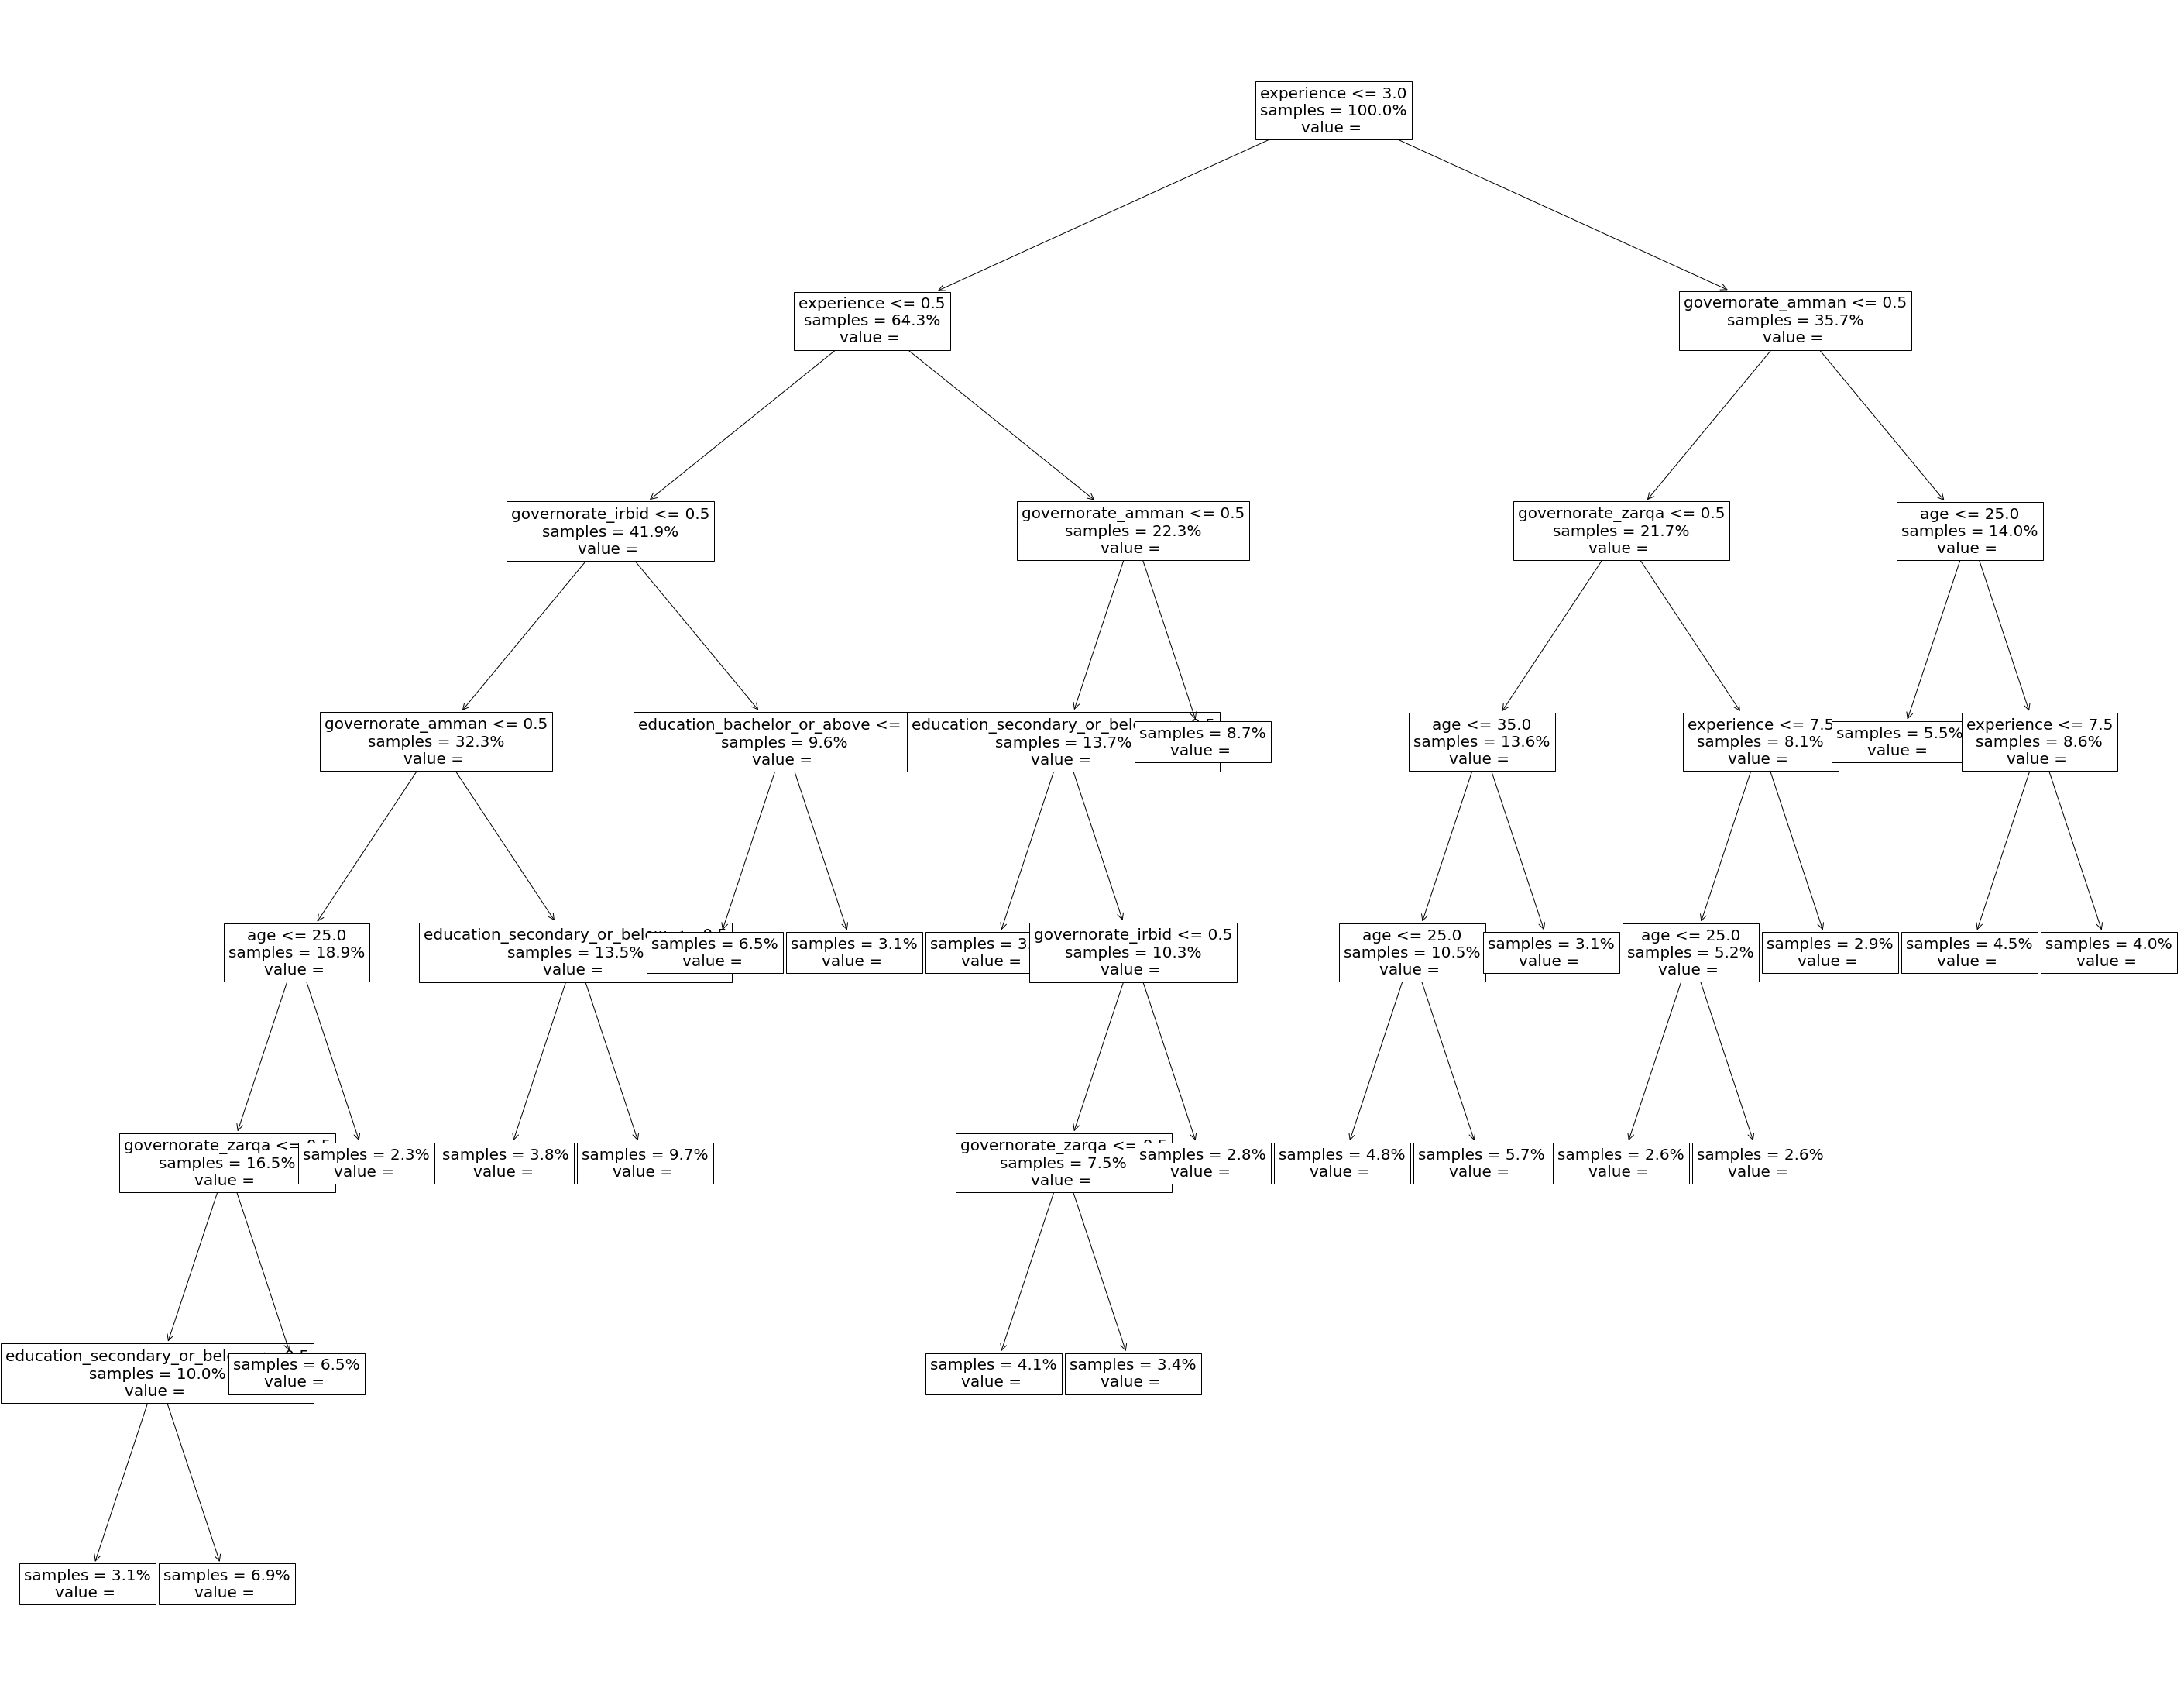

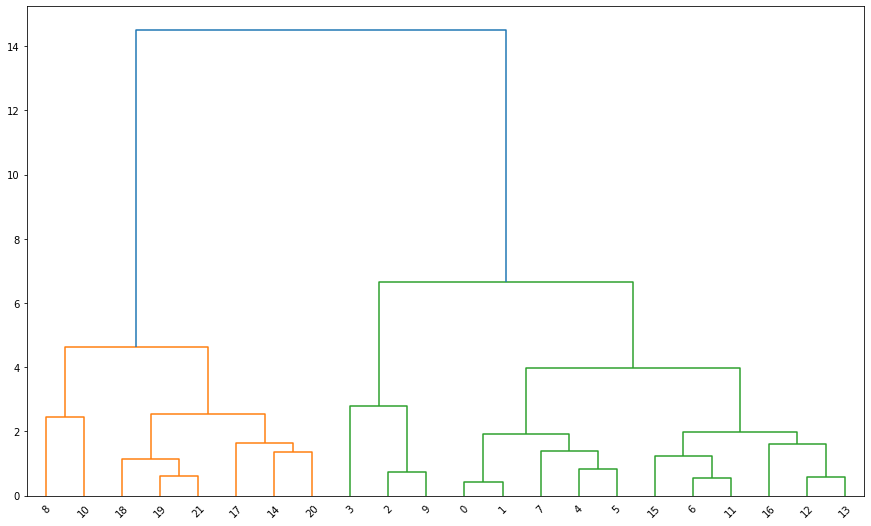

{0: 1, 1: 1, 2: 2, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 2, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0, 15: 1, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Clusters mean durations before mapping           durations
clusters           
0         11.175371
1         12.784224
2         13.861888
1    21252
0     9203
2     3921
Name: clusters, dtype: int64
Clusters mean durations after mapping           durations
clusters           
0         11.175371
1         12.784224
2         13.861888


<Figure size 1080x648 with 0 Axes>

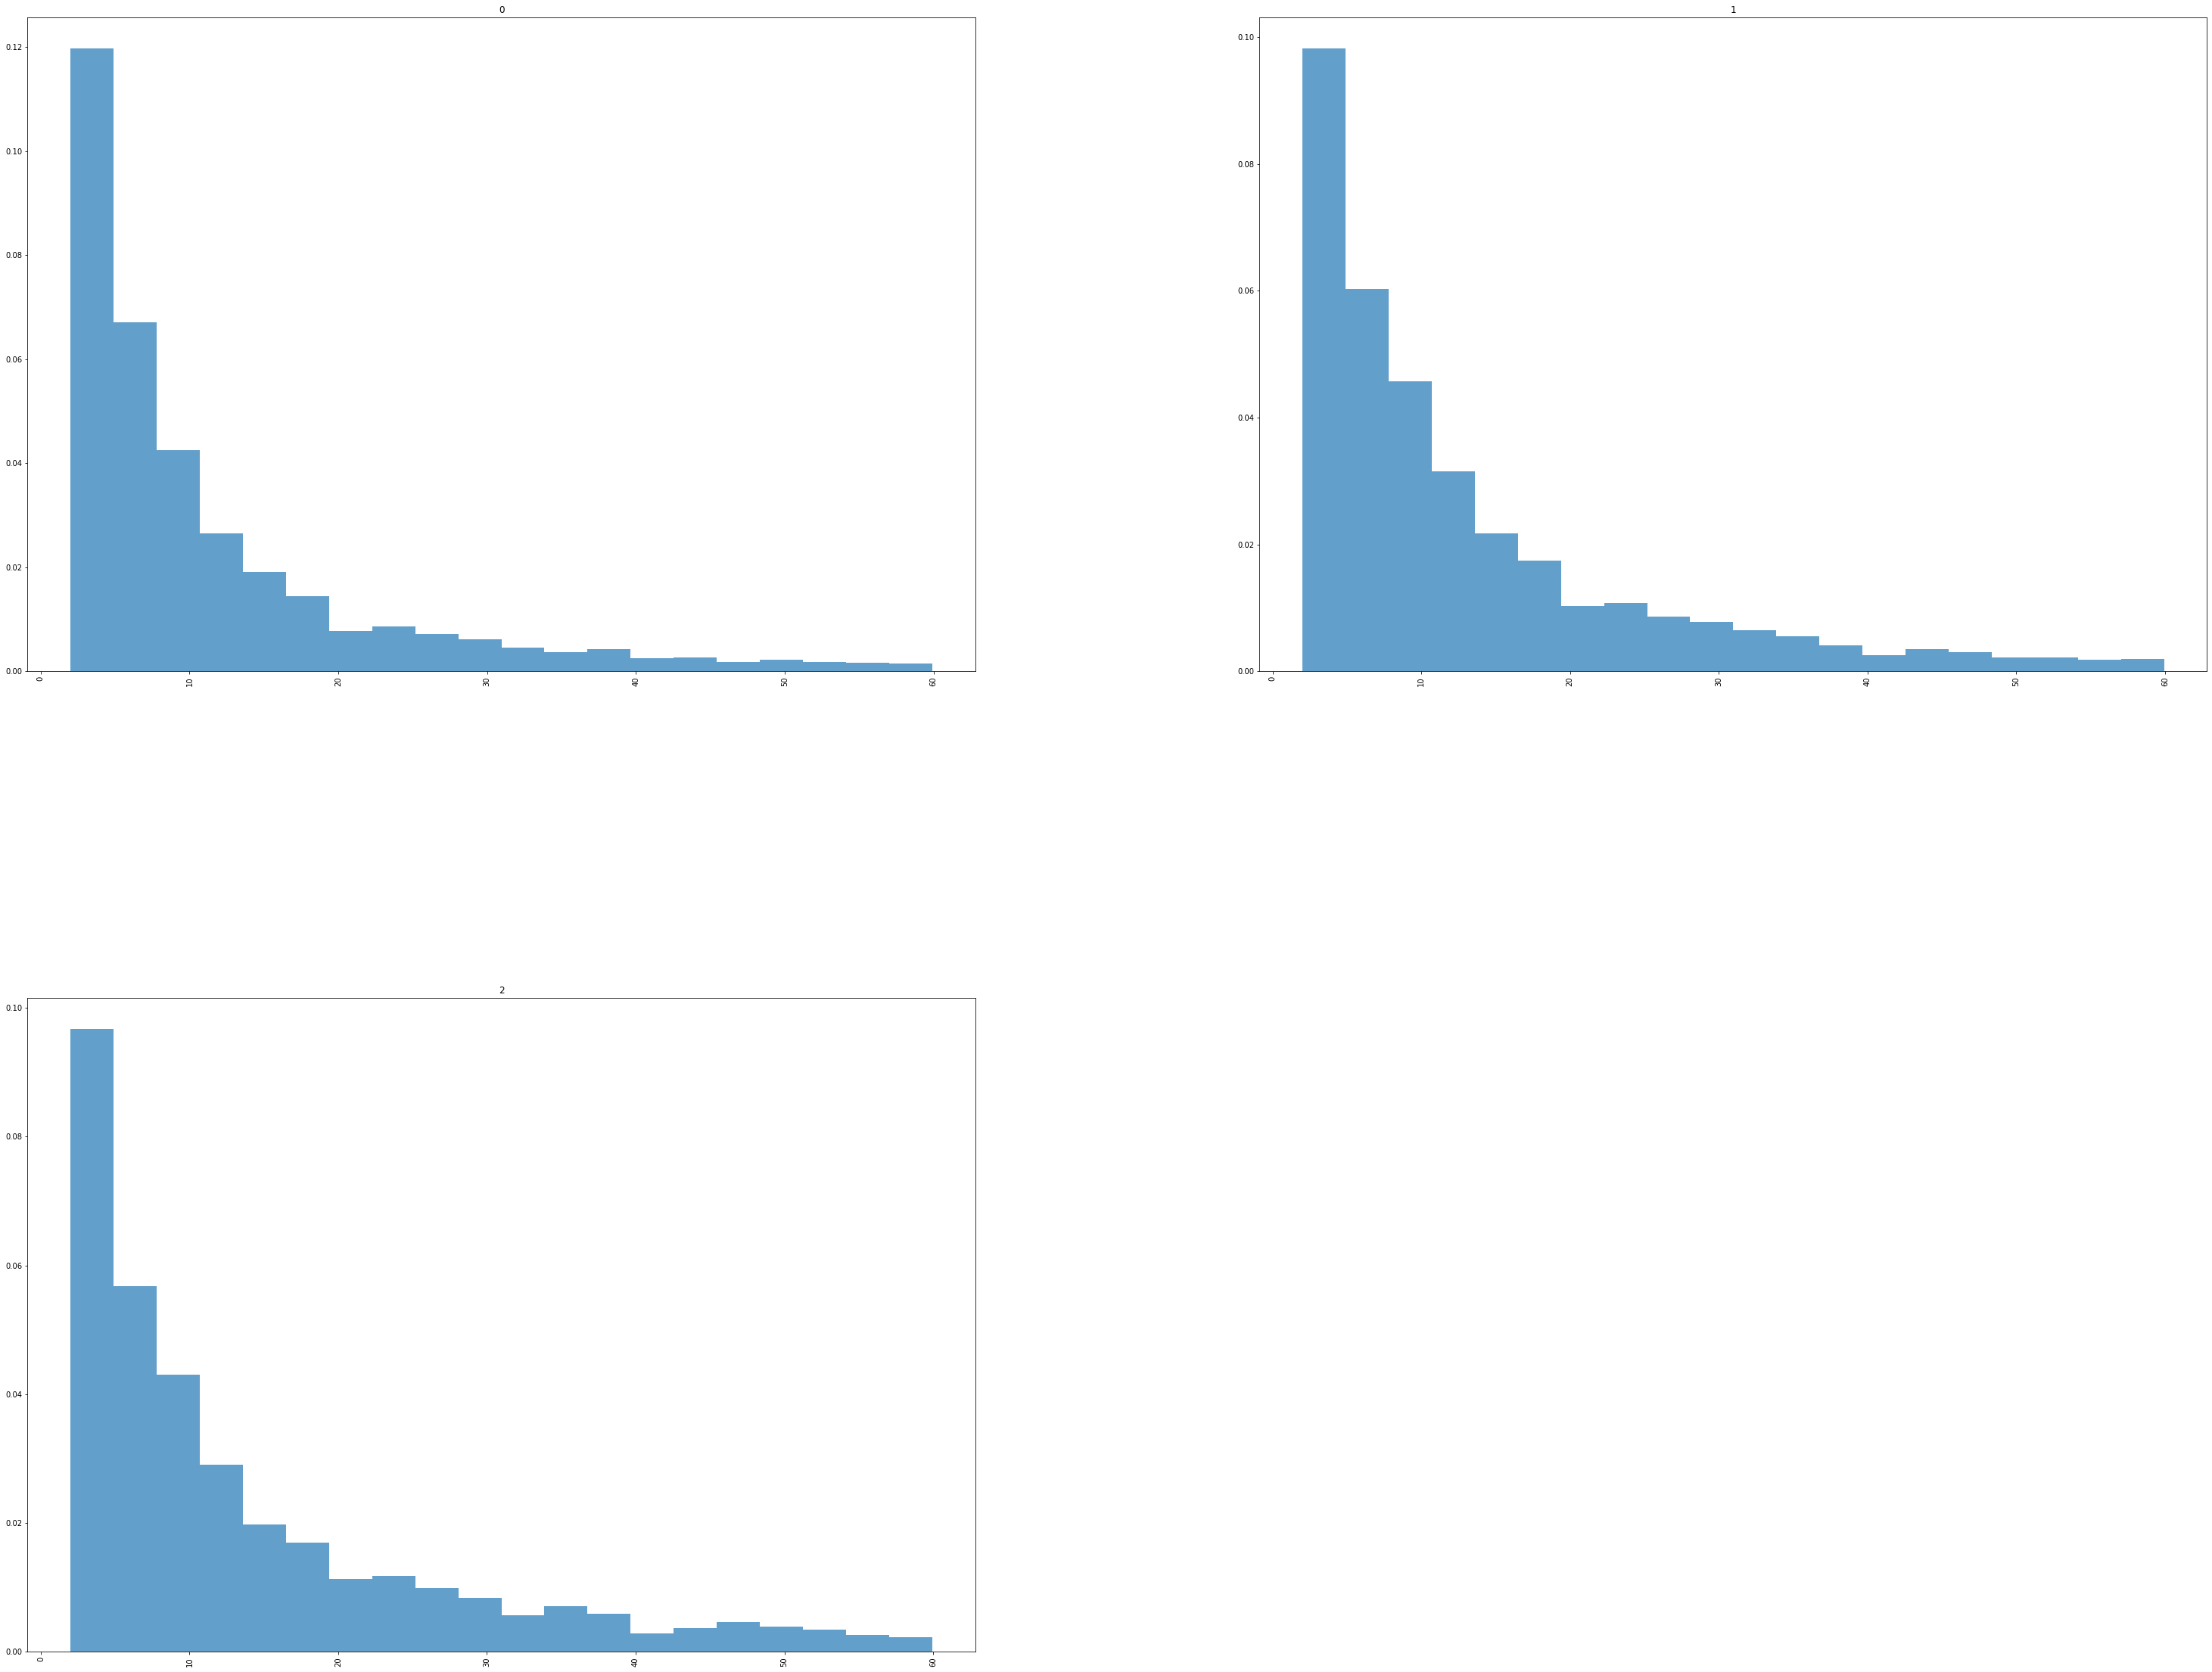

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16335 entries, 0 to 16334
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   experience   16335 non-null  int64 
 1   age          16335 non-null  int32 
 2   governorate  16335 non-null  object
 3   disability   16335 non-null  object
 4   education    16335 non-null  object
dtypes: int32(1), int64(1), object(3)
memory usage: 574.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16335 entries, 0 to 16334
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   experience   16335 non-null  int64 
 1   age          16335 non-null  int32 
 2   governorate  16335 non-null  object
 3   disability   16335 non-null  object
 4   education    16335 non-null  object
dtypes: int32(1), int64(1), object(3)
memory usage: 574.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16335 entries, 0 to 16334


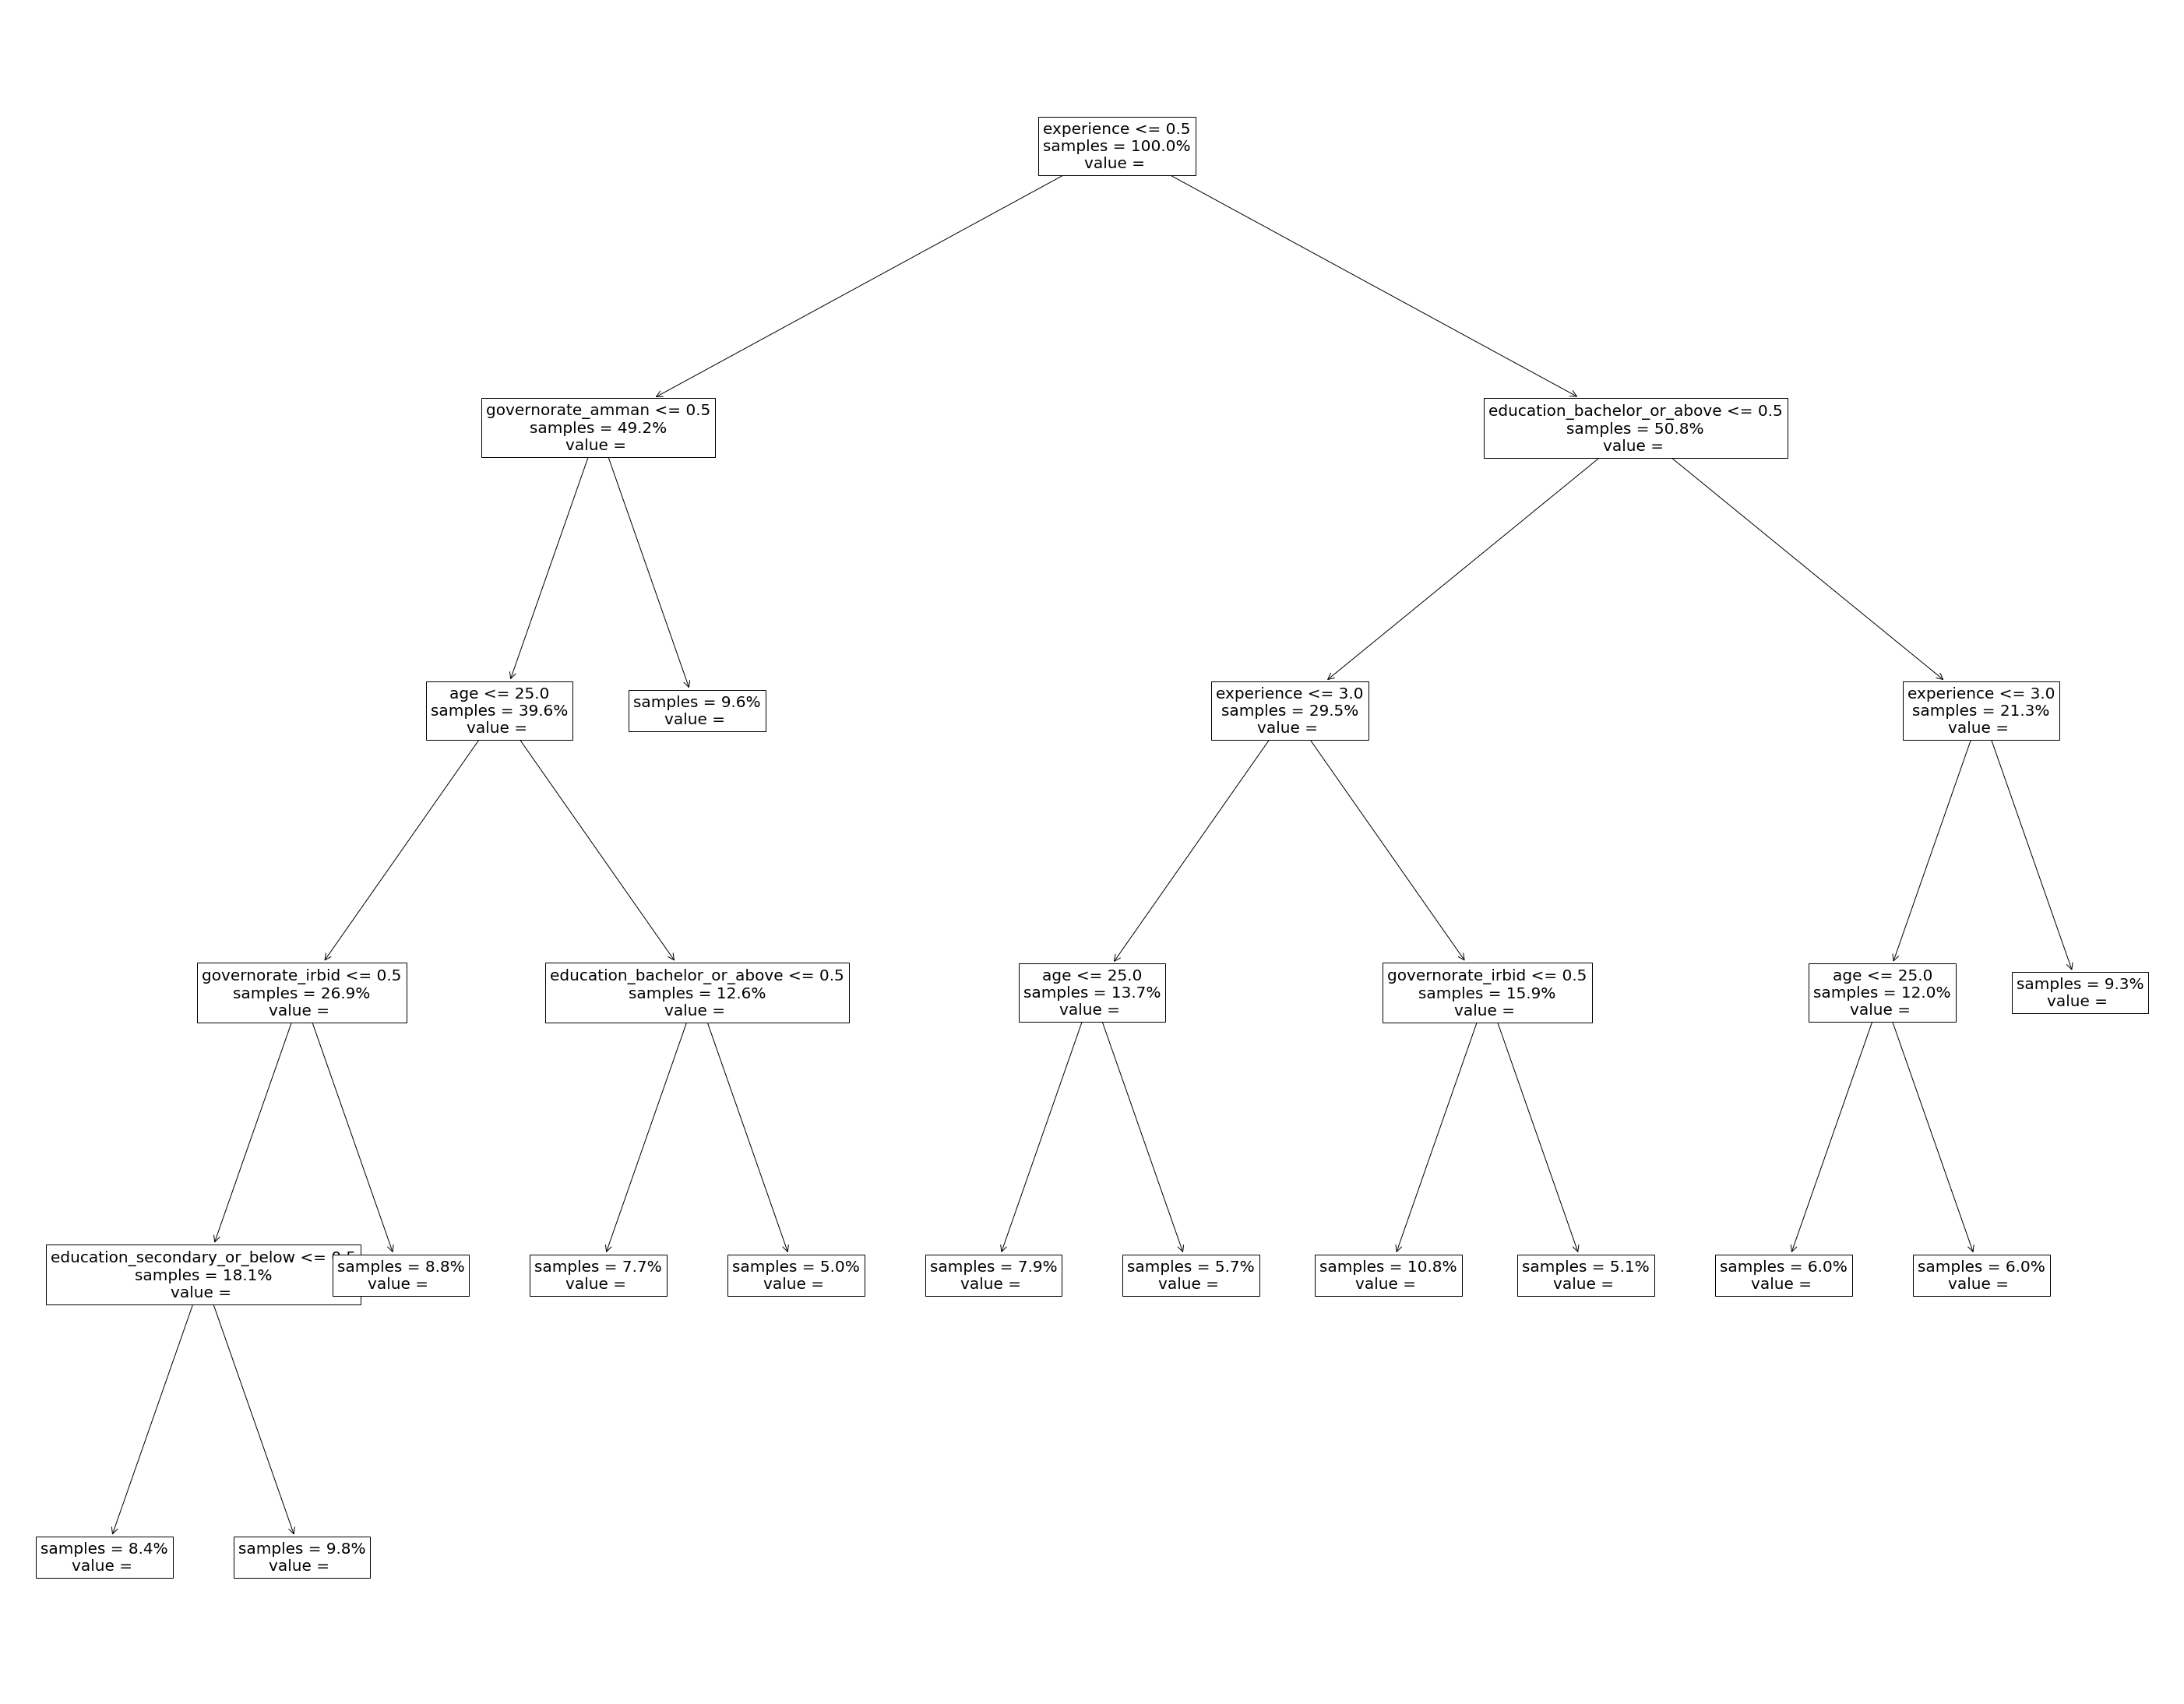

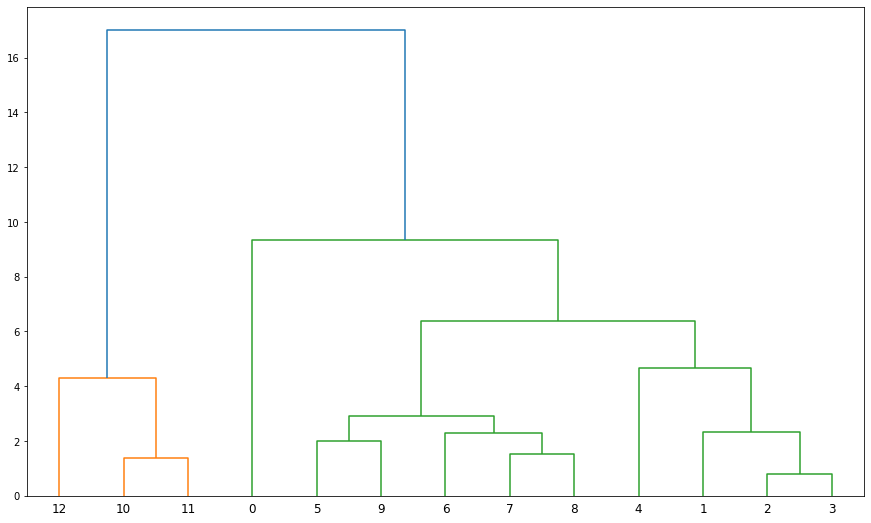

{0: 2, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1}
Clusters mean durations before mapping           durations
clusters           
0         11.242339
1          8.533038
2         14.500144
1    12038
0     3499
2      798
Name: clusters, dtype: int64
Clusters mean durations after mapping           durations
clusters           
0          8.533038
1         11.242339
2         14.500144


<Figure size 1080x648 with 0 Axes>

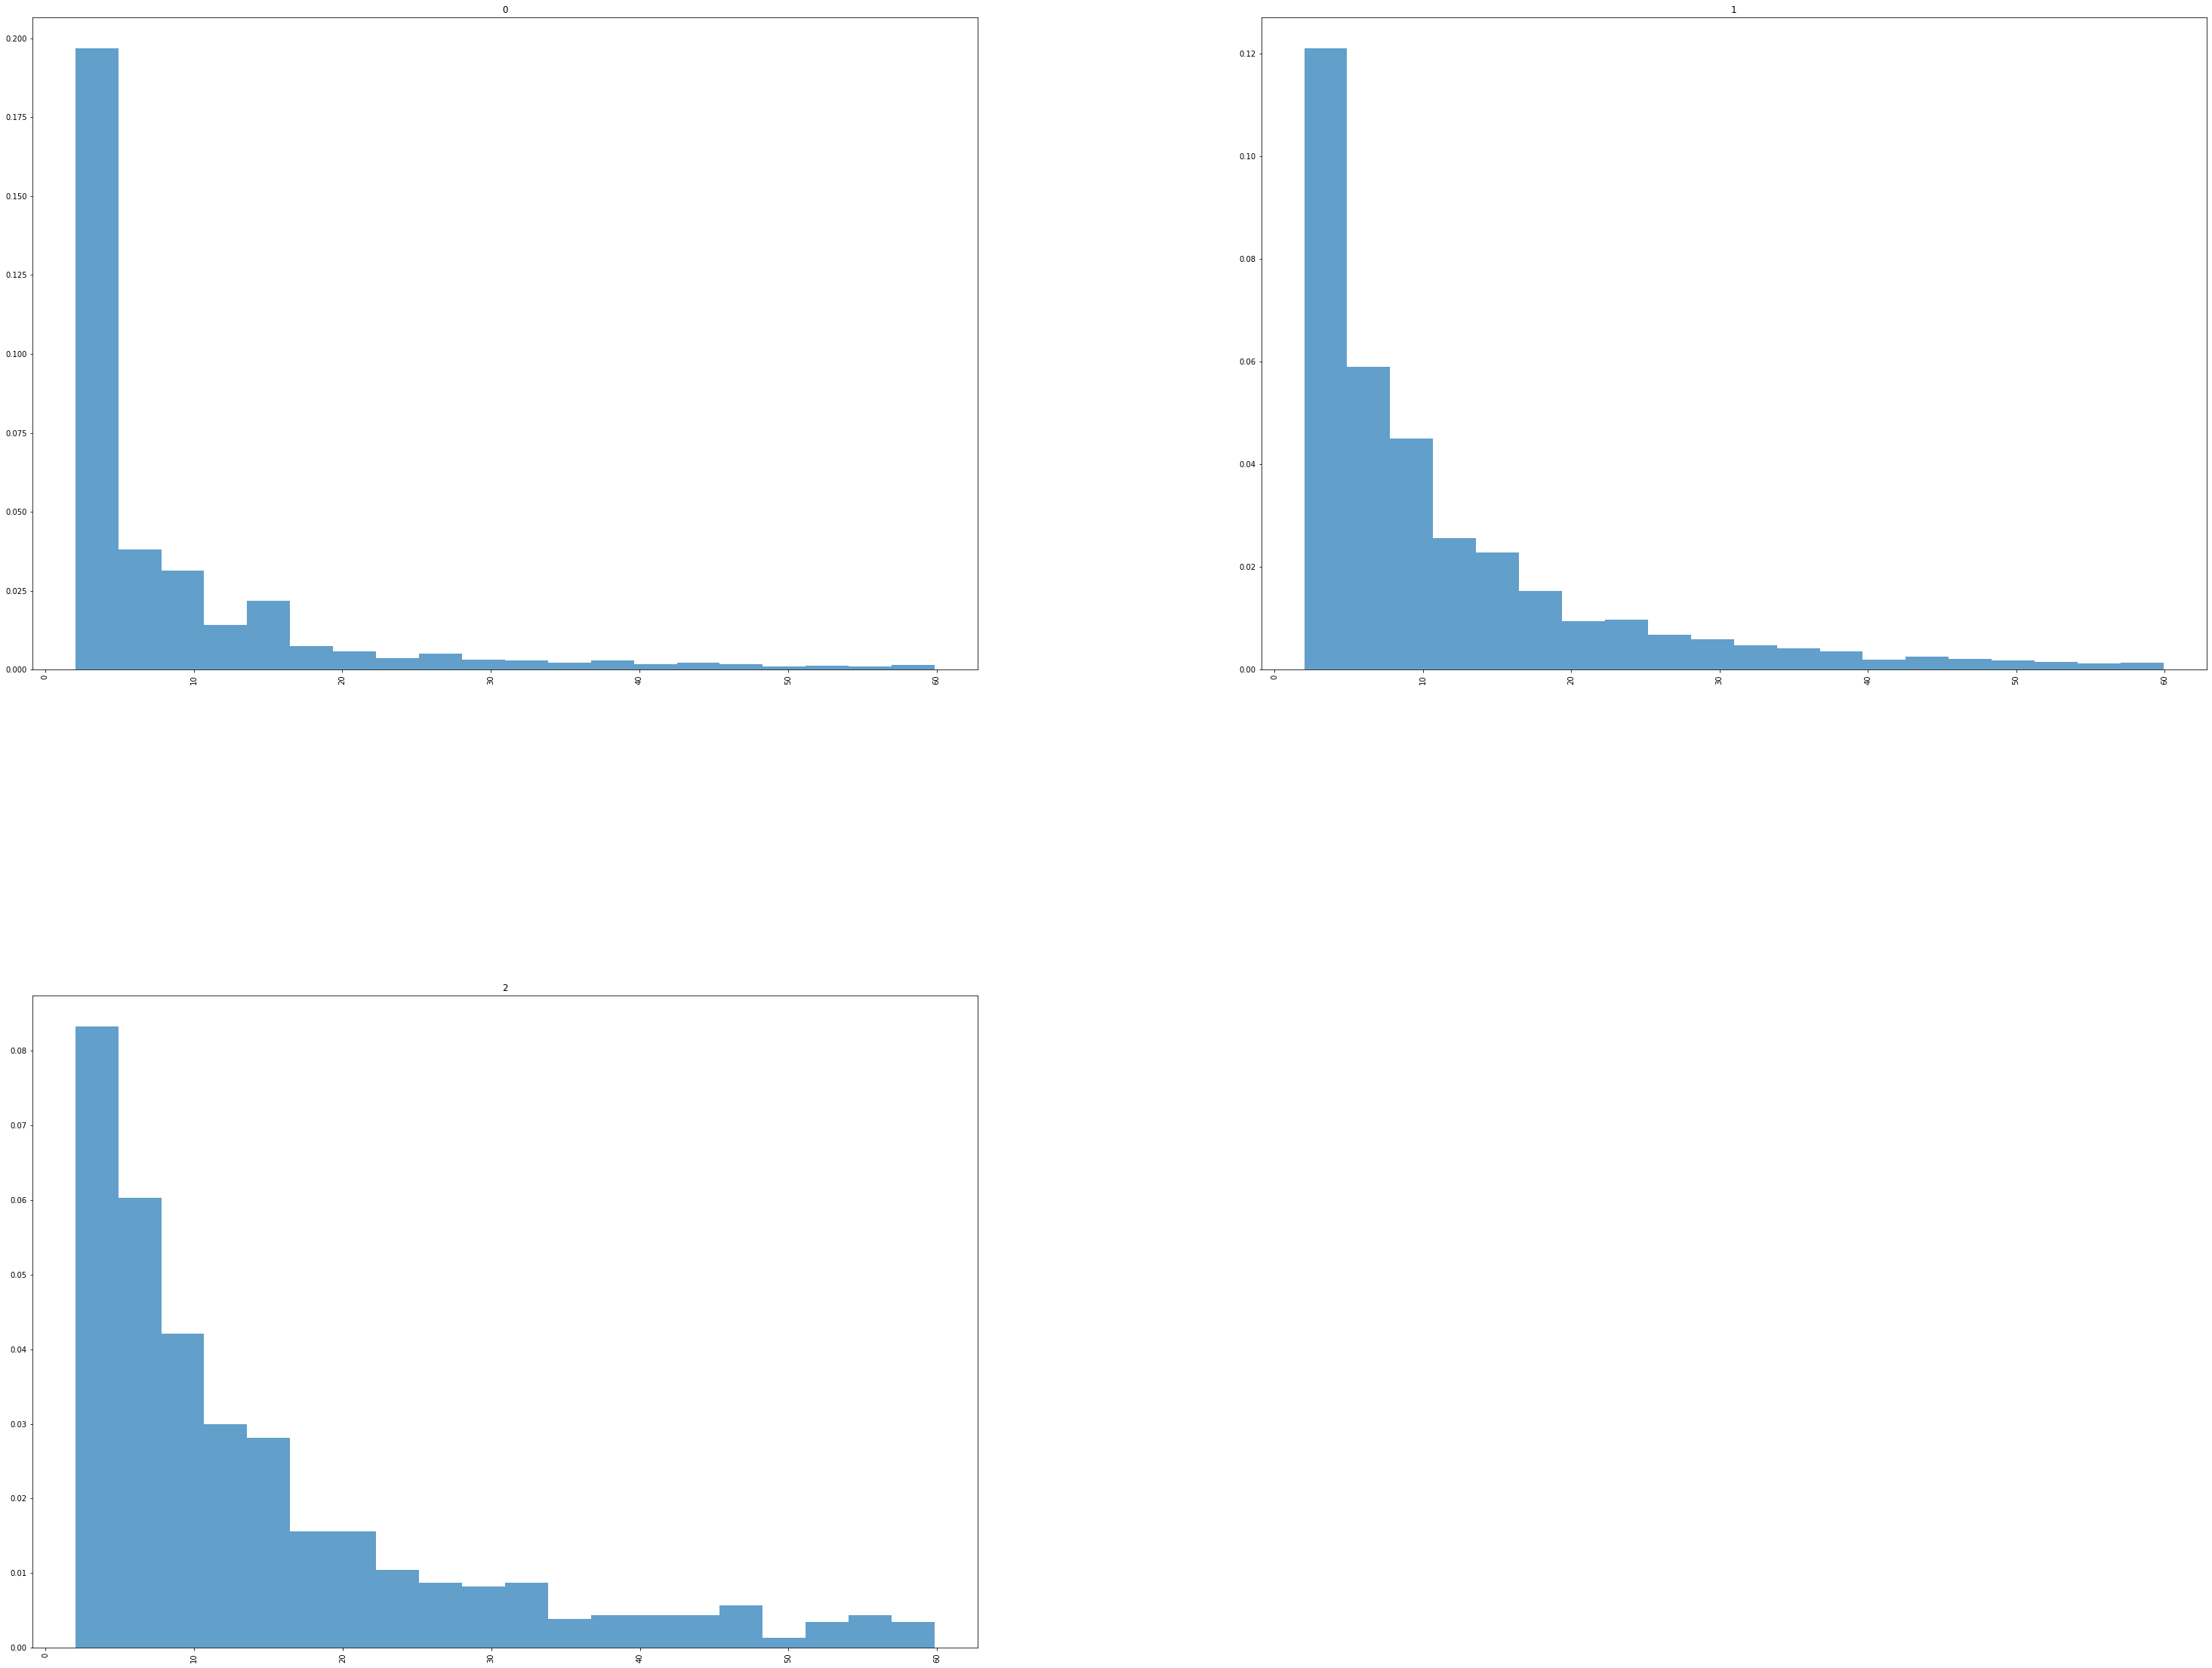

In [22]:
genders = [MALE, FEMALE]
methods = [METHOD3] # METHOD1, METHOD2,

per25 = lambda x: pd.Series(x, name='p25').quantile(0.25)
per75 = lambda x: pd.Series(x, name='p25').quantile(0.75)


if os.path.exists(DATA_OUTPUT_PATH):
    os.remove(DATA_OUTPUT_PATH)

for gen in genders:
    for method in methods:
        temp = advanced_processing(fdf[fdf[GENDER] == gen][METHODS[method][CONTRIBUTORS]], encode=False)
        data = advanced_processing(fdf[fdf[GENDER] == gen][METHODS[method][CONTRIBUTORS]], encode=True)
        print(data.shape)

        target = eval(METHODS[method][TARGET].format('fdf[fdf[GENDER] == gen]')) if '(' in METHODS[method][TARGET] else METHODS[method][TARGET]
        print(target[:5])

        model = build_and_predict(X=data, y=target, )
        print("The total number of leafs is:",  model.tree_.n_leaves)
        print("Biggest leaf has:", np.max(model.tree_.n_node_samples))
        print("Smallest leaf has:", np.min(model.tree_.n_node_samples))
        print("Middel leaf has:", np.median(model.tree_.n_node_samples))
        print("Avg count per leaf:", np.mean(model.tree_.n_node_samples))

        graph = plot_tree(
            model,
            feature_names=model.feature_names_in_,
            impurity=False,
            label="all",
            fontsize=20,
            proportion=True
        )
        data[NODES_DESTRO] = model.predict(data).astype(object)
        encoder = LabelEncoder()
        data[NODES] = encoder.fit_transform(data[NODES_DESTRO])
        data[NODES_DESTRO] = data[NODES_DESTRO].astype(np.float32)
        ENCODERS[NODES] = encoder

    
    data[DURATIONS] = survive(fdf[fdf[GENDER] == gen].drop(GENDER, axis=1), duration=SPELL, event=LAST_JOB)[-1] 
    data = data.reset_index(drop = True)
    # print('-'*200)
    # display(data)
    # print('-'*200)
    
    aggregated_df = data[[DURATIONS, NODES]].groupby(NODES).agg([np.min, np.median, np.std, np.max, np.mean, kurtosis, skew, entropy, per25, per75])
    cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward', compute_full_tree=True, compute_distances=True,)
    cluster.fit(aggregated_df)
    aggregated_df[CLUSTER] = cluster.fit_predict(aggregated_df)
    
    plt.figure(figsize=(15, 9))
    plot_dendrogram(cluster, truncate_mode='lastp' , distance_sort=True)
    plt.show()
    dd = {node:cluster for node, cluster in zip(aggregated_df[CLUSTER].index, aggregated_df[CLUSTER].to_numpy()) }
    print(dd)
    data[CLUSTER] = data[NODES].map(dd)
    
    
    corector = data[[DURATIONS, CLUSTER]].groupby(CLUSTER).mean()
    print('Clusters mean durations before mapping', corector)
    
    cmapper = {
        0: np.argmin(corector), 
        1: np.argsort(corector['durations'])[1],
        2: np.argmax(corector),
    }
    data[CLUSTER] = data[CLUSTER].map(cmapper)

    print(data[CLUSTER].value_counts())
    temp[GENDER] = gen
    temp[CLUSTER] = data[CLUSTER]
    temp[NODES] = data[NODES]
    temp[DURATIONS] = data[DURATIONS]
    
    if os.path.exists(DATA_OUTPUT_PATH):
        temp.to_csv(DATA_OUTPUT_PATH, index=False, mode='a', header=False)
    else:
        temp.to_csv(DATA_OUTPUT_PATH, index=False, mode='a')
    
    print('Clusters mean durations after mapping', data[[DURATIONS, CLUSTER]].groupby(CLUSTER).mean())   
    
    
    plt.figure(figsize=(15, 9))
    data[DURATIONS].hist(by=data[CLUSTER], bins=20, density=True, alpha=0.7, grid=True)
    plt.show()
    
    
    # display(aggregated_df.head())

Below, I am building a DecisionTreeClassifier over the results of the statistical analysis and results above. The benefits of this are.

1- Less implementation time in the API

2- Faster predicting time

3- Less componenet to build in the API part

4- Less preprocessing steps in the API part

5- single and unified referance for modifing the code

Just Have Fun

In [23]:
df = pd.read_csv(DATA_OUTPUT_PATH)[API_ATTRIBUTES+API_TARGET].convert_dtypes(convert_string=False)
if NODES in df.columns:
    df = df.drop(NODES, axis=1)
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50711 entries, 0 to 50710
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   experience   50711 non-null  Int64 
 1   age          50711 non-null  Int64 
 2   governorate  50711 non-null  object
 3   disability   50711 non-null  object
 4   education    50711 non-null  object
 5   gender       50711 non-null  object
 6   clusters     50711 non-null  Int64 
dtypes: Int64(3), object(4)
memory usage: 2.9+ MB
None


,experience,age,governorate,disability,education,gender,clusters
50706,0,20,al_aqaba,no_disability,secondary_or_below,female,1
50707,0,20,amman,no_disability,secondary_or_below,female,1
50708,0,20,amman,no_disability,middle_diploma,female,1
50709,0,20,zarqa,no_disability,secondary_or_below,female,1
50710,0,20,al_kirk,no_disability,secondary_or_below,female,1


In [24]:
df = build_encoders(df, API_ENCODERS, ['governorate', 'disability', 'education', 'gender']).astype(np.int64)
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50711 entries, 0 to 50710
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   experience                     50711 non-null  int64
 1   age                            50711 non-null  int64
 2   disability                     50711 non-null  int64
 3   gender                         50711 non-null  int64
 4   clusters                       50711 non-null  int64
 5   governorate_ajloun             50711 non-null  int64
 6   governorate_al_aqaba           50711 non-null  int64
 7   governorate_al_kirk            50711 non-null  int64
 8   governorate_al_mafraq          50711 non-null  int64
 9   governorate_amman              50711 non-null  int64
 10  governorate_balqa              50711 non-null  int64
 11  governorate_irbid              50711 non-null  int64
 12  governorate_jarash             50711 non-null  int64
 13  governorate_maad

,experience,age,disability,gender,clusters,governorate_ajloun,governorate_al_aqaba,governorate_al_kirk,governorate_al_mafraq,governorate_amman,...,governorate_jarash,governorate_maadaba,governorate_maan,governorate_outside_jordan,governorate_tafileh,governorate_zarqa,education_bachelor_or_above,education_middle_diploma,education_secondary_or_below,education_vocational_training
50706,0,20,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
50707,0,20,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
50708,0,20,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
50709,0,20,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
50710,0,20,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
# dtt = df[df[GENDER] == 1]
features = df[API_CONTRIBUTORS]
target = np.squeeze(df[API_TARGET])
print(features.shape, target.shape)

x_train,x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50711, 21) (50711,)
(40568, 21) (40568,) (10143, 21) (10143,)


In [26]:
for i in range(2, 13):
    api_model = DecisionTreeClassifier(max_depth=i)
    api_model.fit(features, target)
    
    y_pred = api_model.predict(x_train)
    print(f"Model Accuracy on TRAINING data (having max_depth={i}):", accuracy_score(y_train, y_pred))
    print(classification_report(y_train, y_pred, labels=[0, 1, 2]))
    
    y_pred = api_model.predict(x_test)
    print(f"Model Accuracy on TESTING data (having max_depth={i}):", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, labels=[0, 1, 2]))
    
    print('-' * 100)

Model Accuracy on TRAINING data (having max_depth=2): 0.7025241569710117
              precision    recall  f1-score   support

           0       0.57      0.24      0.33     10133
           1       0.72      0.98      0.83     26651
           2       0.00      0.00      0.00      3784

    accuracy                           0.70     40568
   macro avg       0.43      0.41      0.39     40568
weighted avg       0.61      0.70      0.63     40568

Model Accuracy on TESTING data (having max_depth=2): 0.7003845016267376
              precision    recall  f1-score   support

           0       0.56      0.23      0.33      2569
           1       0.72      0.98      0.83      6639
           2       0.00      0.00      0.00       935

    accuracy                           0.70     10143
   macro avg       0.43      0.40      0.39     10143
weighted avg       0.61      0.70      0.63     10143

---------------------------------------------------------------------------------------------

In [27]:
api_model = DecisionTreeClassifier(max_depth=7)
api_model.fit(features, target)

y_pred = api_model.predict(x_train)
print(f"Model Accuracy on TRAINING data:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred, labels=[0, 1, 2]))

y_pred = api_model.predict(x_test)
print(f"Model Accuracy on TESTING data:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Model Accuracy on TRAINING data: 0.9884391638730033
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     10133
           1       1.00      0.98      0.99     26651
           2       1.00      1.00      1.00      3784

    accuracy                           0.99     40568
   macro avg       0.99      0.99      0.99     40568
weighted avg       0.99      0.99      0.99     40568

Model Accuracy on TESTING data: 0.9874790495908509
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2569
           1       1.00      0.98      0.99      6639
           2       1.00      1.00      1.00       935

    accuracy                           0.99     10143
   macro avg       0.98      0.99      0.99     10143
weighted avg       0.99      0.99      0.99     10143



|--- feature_0 <= 3.00
|   |--- feature_19 <= 0.50
|   |   |--- feature_7 <= 0.50
|   |   |   |--- feature_17 <= 0.50
|   |   |   |   |--- feature_6 <= 0.50
|   |   |   |   |   |--- feature_0 <= 0.50
|   |   |   |   |   |   |--- feature_1 <= 25.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_1 >  25.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_0 >  0.50
|   |   |   |   |   |   |--- feature_3 <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_3 >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_6 >  0.50
|   |   |   |   |   |--- feature_0 <= 0.50
|   |   |   |   |   |   |--- feature_3 <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_3 >  0.50
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- feature_0 >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- feature_17 >  0.50
|   |   |   |   |--- f

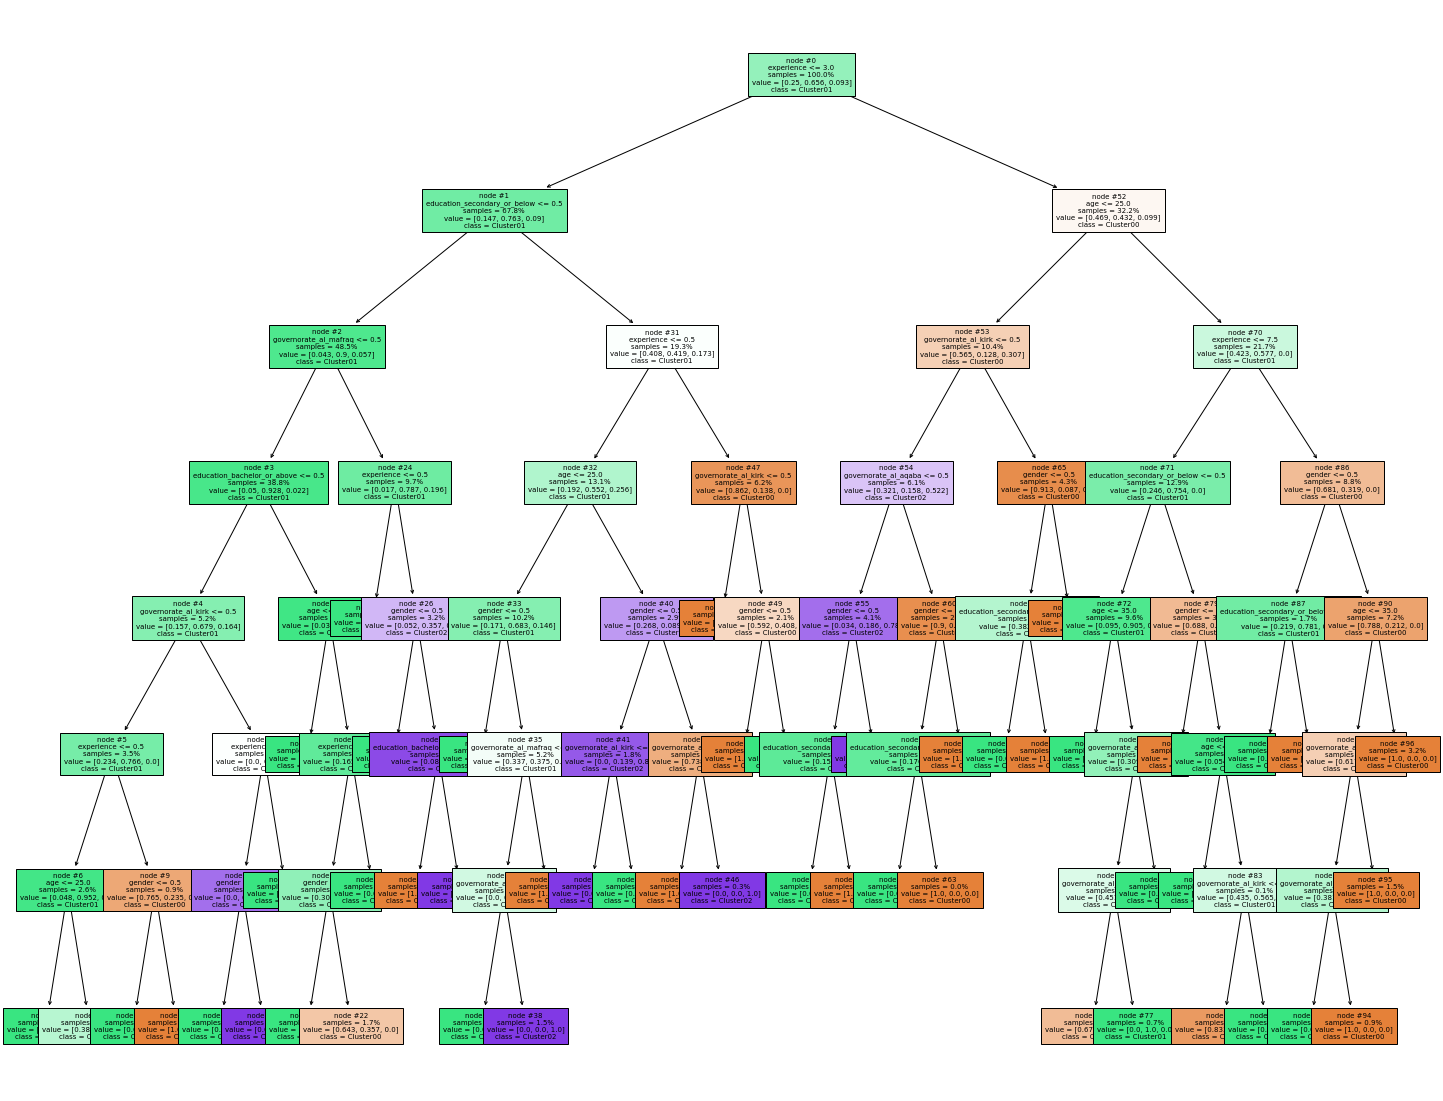

In [28]:
text_representation = tree.export_text(api_model)
print(text_representation)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(
    api_model, 
    feature_names=df.drop(CLUSTER, axis=1).columns,  
    class_names=['Cluster00', 'Cluster01', 'Cluster02', ],
    filled=True,
    proportion=True,
    fontsize=7,
    impurity=False,
    node_ids=True
)

In [31]:
predect_node_for_missing_value(api_model, [0, 20, 0, 1, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

The binary tree structure has 97 nodes, 49 leaves and has the following tree structure:

current_node is 0 ::: node=0 is a split node: go to node 1 if X[:, 0 experience] <= 3.0 else to node 52.
current_node is 1 :::     node=1 is a split node: go to node 2 if node 2 counts 24612 >= node31 counts9777 else to node 31.
current_node is 2 :::         node=2 is a split node: go to node 3 if node 3 counts 19675 >= node24 counts4937 else to node 24.
current_node is 3 :::             node=3 is a split node: go to node 4 if node 4 counts 2652 >= node17 counts17023 else to node 17.
current_node is 17 ::: current_node is 17 ::: current_node is 17 ::: current_node is 17 ::: 							node=7 is a leaf node.
current_node is 17 ::: 							node=8 is a leaf node.
current_node is 17 ::: current_node is 17 ::: 							node=10 is a leaf node.
current_node is 17 ::: 							node=11 is a leaf node.
current_node is 17 ::: current_node is 17 ::: current_node is 17 ::: 							node=14 is a leaf node.
current_node is 

(18, 1)

In [32]:
for encoder in API_ENCODERS:
    joblib.dump(API_ENCODERS[encoder], os.path.join(MODELS_OUTPUT_PATH, f'{encoder}_encoder.joblib'))
joblib.dump(api_model, os.path.join(MODELS_OUTPUT_PATH, 'model.joblib'))

['.\\runs\\model.joblib']

In [36]:
# !ls -ltr ./runs/